Training the XGBoost model with SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:51:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- XGBoost Model Evaluation Results ---
ROC AUC Score: 0.7473

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.55      0.09      0.16      5931

    accuracy                           0.89     51070
   macro avg       0.72      0.54      0.55     51070
weighted avg       0.85      0.89      0.85     51070



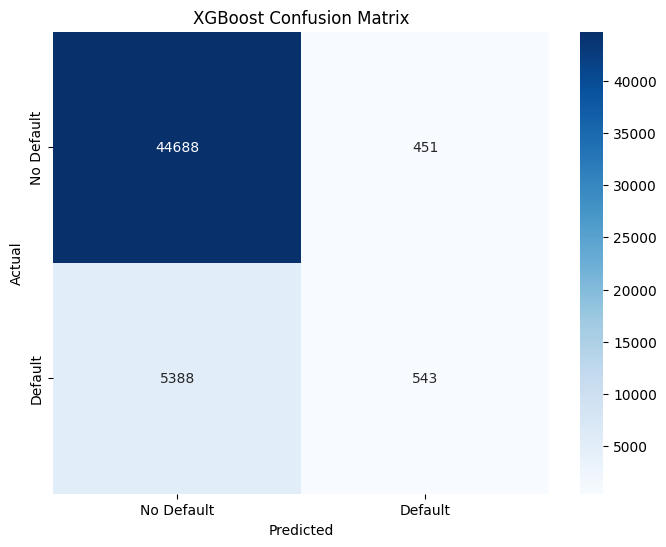

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

try:
    # --- 1. Load and Clean Data ---
    df = pd.read_csv('Loan_default.csv')
    df.dropna(inplace=True) # Robustness step to remove any missing values

    # --- 2. Data Preparation ---
    X = df.drop(columns=['LoanID', 'Default'])
    y = df['Default']

    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 3. Preprocessing and Model Pipeline ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    # Create the XGBoost Classifier model
    xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Create an imbalanced-learn pipeline to handle SMOTE correctly
    model_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgboost_model)
    ])

    # --- 4. Train the Model ---
    print("Training the XGBoost model with SMOTE...")
    model_pipeline.fit(X_train, y_train)
    print("Training complete.")

    # --- 5. Evaluate the Model ---
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("\n--- XGBoost Model Evaluation Results ---")
    print(f"ROC AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(report)

    # --- 6. Visualization ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


except FileNotFoundError:
    print("Error: Loan_default.csv not found.")
except ImportError:
    print("Error: A required library is not installed.")
    print("Please run: pip install xgboost scikit-learn pandas matplotlib seaborn imbalanced-learn")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
Analysis of the XGBoost Results
Extremely Low Recall (9%): The recall for the 'Default' class is only 0.09. This means the model is only catching 9% of all customers who actually end up defaulting. This is a critical failure for a risk assessment model.

Precision (55%): When the model does predict a default, it's correct 55% of the time. While this isn't terrible, it doesn't compensate for the fact that it misses most of the defaults.

ROC AUC Score (0.7473): This score is decent but lower than what we would expect from the previous model, and it masks the severe recall problem.